# Preprocessing and Filtering

### Things to achieve in this notebook

- This notebook carries on from location inference (sentiment is recalculated as the location inference code is designed to take in complete tweet objects)
- Open the data and get it in a form you can use           
- Bot removal
- Relevance filtering

In [180]:
## Import libraries

import matplotlib.pyplot as plt                               # Used for plotting data
from collections import Counter                               # This is used to count occurances of values
import pandas as pd                                           # Used for cleanly displaying data
import numpy as np                                            # Collection of mathematical functions
import tarfile                                                # Used for extracting files
import json                                                   # Processing individual JSON files uses this
import csv                                                    # This was used to create and read csvs
import string
import pickle
import os                                                     # This helped locate and delete json files
import re
import random
import operator
import nltk
from nltk.corpus import stopwords
from ast import literal_eval                                  # Used to convert strings to dict
from datetime import datetime                                 # This processes different date formats
from pandas.plotting import register_matplotlib_converters    # This had to be registered to allow for timeseries plots
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from emoji import demojize
from langdetect import detect
from multiprocessing import Process
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import  confusion_matrix
register_matplotlib_converters()
pd.set_option('display.max_rows', 10)                         # Setting displayed panda length

## Preliminary Checks

### To Do:

- Open the data and get it in a form you can use             
- Plot a time series to check for down days etc.
- Language analysis

#### Opening Data

In [57]:
File_Locations = 'C:/Users/beckr/Documents/Uni_Work/Masters/Advanced_Project/Data/located_tweets/'

if os.path.exists('HeatCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatCSV.csv')

with open('HeatCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    for filename in os.listdir(File_Locations):                                     # Iterates through the files to extract
        with open((File_Locations + filename), mode='r', encoding='utf-8') as current:     
                
            for line in current:
                
                new_line = literal_eval(line)
                writer.writerow(new_line[0] + new_line[1])

In [58]:
# For ease of indexing

ID = 0
timestamp = 1
place = 2
text = 3
coord = 4
sentiment = 5

#### Time Series

In [59]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatCSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  266240


In [ ]:
tweetcount = Counter()                                              # Initialise counter
with open('HeatCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

In [ ]:
lists = sorted(tweetcount.items())                                  # Sorting and seperating the data
day, quant = zip(*lists)

plt.figure(figsize = [18,5])
plt.plot(day,quant)
plt.title('Timeseries plot of date to daily tweet count', size = 13)
plt.xlabel('Date')
plt.ylabel('Tweet count')
plt.show()

#### Language analysis

In [ ]:
# Count how many undifined tweets are english language
countEng = 0

if os.path.exists('HeatEngCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatEngCSV.csv')

with open('HeatEngCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
                             
            try: dt = detect(demojize(line[text]))
            except:
                continue
            if dt == 'en':
                writer.writerow(line)
                countEng = countEng + 1

print(countEng)

## Sentiment Analysis

### To Do:

- Sentiment analysis
- Time series
- Mapping

#### Sentiment Analysis

In [9]:
analyzer = SentimentIntensityAnalyzer()

In [29]:
if os.path.exists('HeatSentCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatSentCSV.csv')

with open('HeatSentCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatEngCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            if len(line) == 5:  # Ensure all fields have entries
        
                vs = analyzer.polarity_scores(line[text])
                sent = vs['compound']

                newline = line + [sent]

                writer.writerow(newline)

#### Create Time series
 - use average sentiment

In [30]:
tweetcount = Counter()                                              # Initialise counter
with open('HeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

In [31]:
df = pd.DataFrame.from_dict(tweetcount, orient = 'index')
df.index.name = 'Date'
df['sent'] = 0
i = 0
with open('HeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        i = i+1
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = (datetime.utcfromtimestamp(ts).date())                 # Turn ts into date
        new = df.at[Date, 'sent'] + float(line[sentiment])
        df.loc[Date, 'sent'] = new
        
df['sent']=df['sent']/df[0]

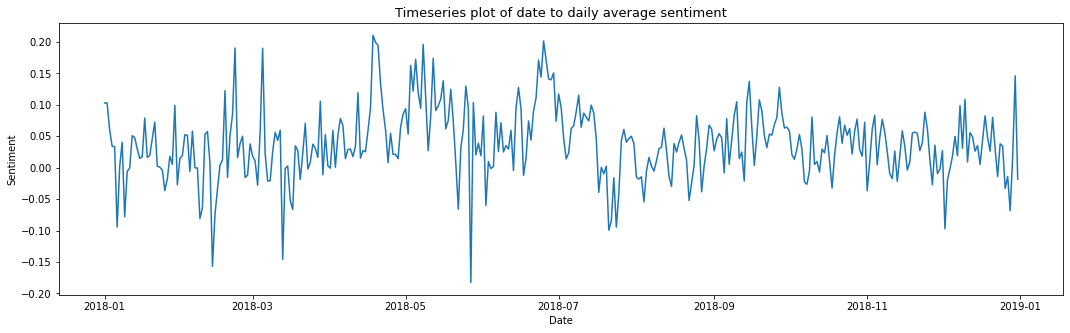

In [32]:
df = df.reset_index()
df = df.sort_values(by='Date')

plt.figure(figsize = [18,5])
plt.plot(df['Date'],df['sent'])
plt.title('Timeseries plot of date to daily average sentiment', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

## Bot Removal

In [36]:
from collections import Counter

uniqueID = Counter()

with open('HeatSentCSV.csv','r', encoding='utf-8') as csvfile:   # Simple loop to add to the above counters
    read = csv.reader(csvfile)
    for line in read:
        
        uniqueID[line[ID]] +=1
        
print('unique ID:', len(uniqueID))

unique ID: 256355


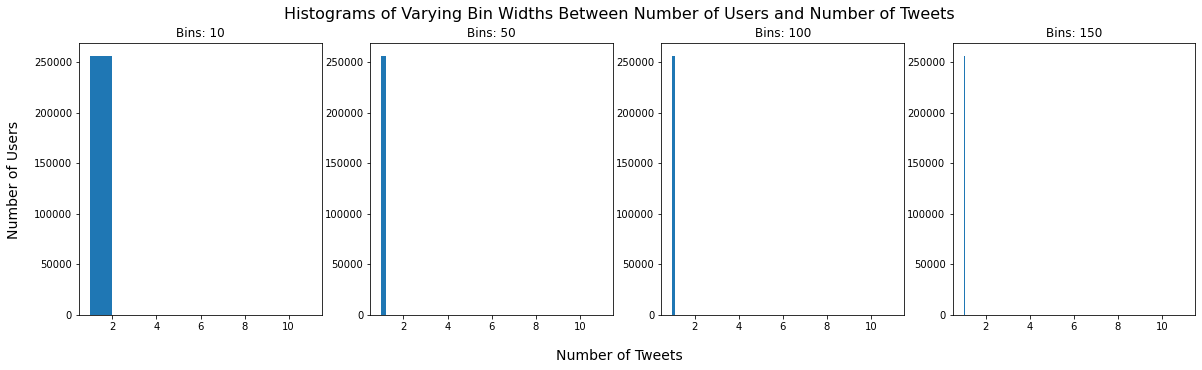

In [37]:
userfreq = sorted(uniqueID.values())                           # Taking just the counts of the counter

fig, axs = plt.subplots(1, 4, figsize = (20,5))

for i, bins in enumerate([10,50,100,150]):                     # Plotting the histograms and annotating them below.
    axs[i].hist(x = userfreq, bins = bins)
    axs[i].set_title(label = 'Bins: %i'% bins)
    
plt.suptitle('Histograms of Varying Bin Widths Between Number of Users and Number of Tweets', size = 16)
fig.text(0.5, 0.0, 'Number of Tweets', ha='center', size = 14)
fig.text(0.075, 0.5, 'Number of Users', va='center', rotation='vertical', size = 14)
plt.show()

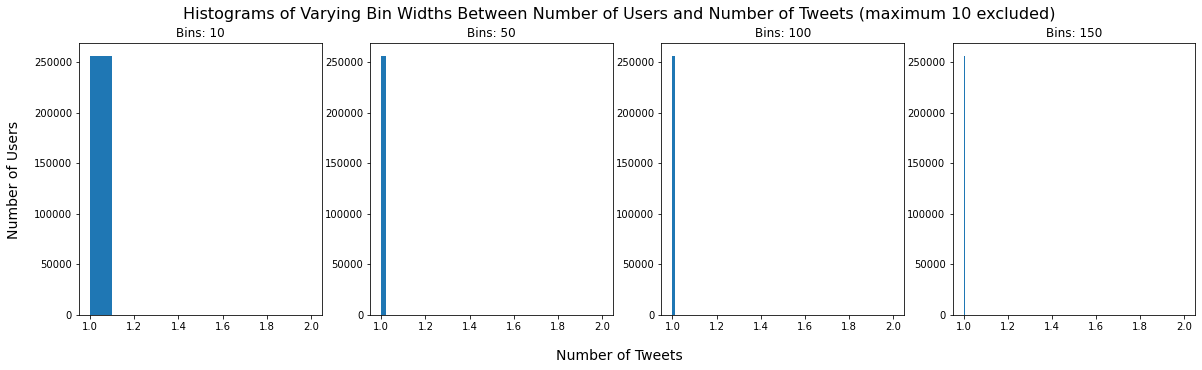

In [38]:
fig, axs = plt.subplots(1, 4, figsize = (20,5))

for i, bins in enumerate([10,50,100,150]):                     # Plotting the histograms and annotating them below.
    axs[i].hist(x = userfreq[:-10], bins = bins)
    axs[i].set_title(label = 'Bins: %i'% bins )

plt.suptitle('Histograms of Varying Bin Widths Between Number of Users and Number of Tweets (maximum 10 excluded)', size = 16)
fig.text(0.5, 0.0, 'Number of Tweets', ha='center', size = 14)
fig.text(0.075, 0.5, 'Number of Users', va='center', rotation='vertical', size = 14)
plt.show()

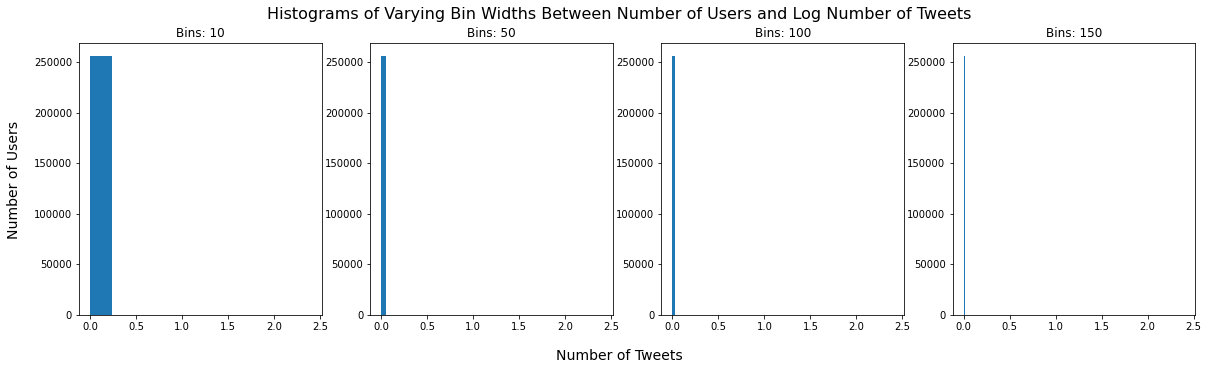

In [39]:
fig, axs = plt.subplots(1, 4, figsize = (20,5))

for i, bins in enumerate([10,50,100,150]):                     # Plotting the histograms and annotating them below.
    axs[i].hist(x = np.log(userfreq), bins = bins)
    axs[i].set_title(label = 'Bins: %i'% bins )
    
plt.suptitle('Histograms of Varying Bin Widths Between Number of Users and Log Number of Tweets', size = 16)
fig.text(0.5, 0.0, 'Number of Tweets', ha='center', size = 14)
fig.text(0.075, 0.5, 'Number of Users', va='center', rotation='vertical', size = 14)
plt.show()    

Although none tweet excessively it is worth noting all these tweets have the word heat, heatwave of drought in them,

In [40]:
uniqueID.most_common(10)

[('963958541601173504', 11),
 ('992498535231877120', 7),
 ('986364975978598400', 3),
 ('988964066348515328', 3),
 ('1012800279635521536', 3),
 ('1012817016498028555', 3),
 ('949551626133622784', 2),
 ('950463942186491904', 2),
 ('950579652422123520', 2),
 ('950778205971005440', 2)]

In [44]:
AltNames = {}                                                   # Dictionary for holding alternative names

with open('HeatCSV.csv','r', encoding='utf-8') as csvfile:   
    read = csv.reader(csvfile)
    
    for line in read: 
        
        if line[ID] not in AltNames:                            # Adds first instance of screen name
            AltNames[line[ID]] = [line[ID]]
            
        if line[ID] not in AltNames[line[ID]]:         # Adds additional screen names for user to dictionary
            temp = AltNames[line[ID]]
            temp.append(line[ID])
            AltNames[line[ID]] = temp

orderedID, _ = zip(*uniqueID.most_common(10))

for i in orderedID:                                             # Prints top 10 tweets alternative screen names
    print(i,':',AltNames[i])

963958541601173504 : ['963958541601173504']
992498535231877120 : ['992498535231877120']
986364975978598400 : ['986364975978598400']
988964066348515328 : ['988964066348515328']
1012800279635521536 : ['1012800279635521536']
1012817016498028555 : ['1012817016498028555']
949551626133622784 : ['949551626133622784']
950463942186491904 : ['950463942186491904']
950579652422123520 : ['950579652422123520']
950778205971005440 : ['950778205971005440']


In [46]:
SampledTop10 = {}
np.random.seed(0)                                 # Seed for random numbers (set as 0 for below interpretation to apply)

with open('HeatCSV.csv','r', encoding='utf-8') as csvfile:
    read = csv.reader(csvfile)
    for line in read:
        
          if line[ID] in orderedID:                                # Checks if ID is one of top 10 tweeters
                tempID = line[ID]               

                if tempID not in SampledTop10:                 # Checks if first instance of tweeter

                    temp = {}                                  # Makes dict for holding top 10
                    temp[0] = line[text]                      
                    SampledTop10[tempID] = temp                # Adds first tweet
                    continue

                lentweets = len(SampledTop10[tempID])          

                if lentweets < 10:                             # We only require 10 tweets from each user so this checks

                    temp = SampledTop10[tempID]
                    temp[lentweets] = line[text]
                    SampledTop10[tempID] = temp
                    

pd.set_option('display.max_rows', 100)                                             # Allows for full df to be displayed
df  = pd.DataFrame.from_dict(SampledTop10, orient = 'index').reindex(orderedID)    # Sorts the df for easy reading
pd.melt(df.T, id_vars = None).groupby( ['variable','value'],sort = False).first()


,
variable,value
963958541601173504,#MHANews Extreme concern over mental welfare of drought affected Hunter farmers @DairyConnect @shaughn_morgan https://t.co/gDbb2aEWM6
992498535231877120,What do you think about this #safrinha cornfield?\n#drought\n#agro\n#brazil https://t.co/fBO5Ai8n7X
986364975978598400,#NowPlaying Heatwave - Mind Blowing Decisions (Extended Remix Version) #listenlive https://t.co/CHvdihuf4U
988964066348515328,"@HasibaAmin What about 60 years loot..... You guys are so excited as if nothing bad, corruption, scams, war, emerge https://t.co/Qs31bkuoMj"
1012800279635521536,Heatwave to continue into next week as Londoners bask in 28C heat https://t.co/z2hsRNRYEb
1012817016498028555,Ive a feeling the alcohol sales will be through the roof this week. #heatwave
949551626133622784,Bushfires destroy buildings in Australia as heatwave melts highway surface https://t.co/58URrxkSqK
950463942186491904,#Grinding #MondayMotivation #heatwave #BiboOutNow #SnapLezz #hiphop #HipHopMusic https://t.co/NU3Z9g6Fcf
950579652422123520,Bats brains boil in Australia heatwave https://t.co/NEAluRImnn https://t.co/1WDyOvIwWh


**If you find bots remove them**
Write a new csv where you write a row if username isn't in list. The following appear to be news tweets or all tweets from the user follow the same format. We remove all of these as they do not show personal reponses to heat.

In [47]:
bot_list = ('963958541601173504', '986364975978598400', '1012800279635521536', '949551626133622784',
            '950463942186491904', '950579652422123520', '950778205971005440')

In [49]:
if os.path.exists('HeatBotCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatBotCSV.csv')

with open('HeatBotCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)

        for line in read:

            test_string = line[ID]
            res = [ele for ele in bot_list if(ele in test_string)]
            if str(bool(res)) == 'False':
                writer.writerow(line)
                

In [50]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatBotCSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  256539


## Relevance Checks
- Weather Station filter
- Unrelated terms filter

#### Weather station filter

- Removes tweets with more than two weather terms
- Wind, Barometer, Temperature, Rain, Humidity

In [51]:
test_list = ['Wind', 'Barometer', 'Temperature', 'Rain', 'Humidity', 'wind', 'barometer', 'temperature', 'rain', 'humidity']

In [53]:
if os.path.exists('HeatFilter1CSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatFilter1CSV.csv')

with open('HeatFilter1CSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatBotCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            test_string = line[text]
            count = 0
            for word in test_list:
                res = word in test_string
                if str(bool(res)) == 'True':
                    count = count + 1
            if count < 3: 
                writer.writerow(line)

In [54]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatFilter1CSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  256522


#### Unrealated terms filter
- Think of some phrases not related to the weather that have the search words in
- Words containing search words: 'theatre', 'cheat' etc.
- Music/phrases :'love drought', 'EXO', songs by Heatwave - Thought about removing wiley but people often tweet about this song in relation to the weather.
- Looking at the tweets radio stations often write 'NOW PLAYING' this is something I could filter out
- Tweets with colons tend to be news or radio etc - genuine accounts don't seems to use colons (although emoticons!)

In [55]:
test_list = ['love drought', 'theatre', 'cheat', 'Love Drought', 'Theatre', 'Cheat', 
            'EXO', 'exo', 'Now Playing', 'NOW PLAYING', 'grooveline', 'Groove Line', 'Boogie Nights', 'boogie nights',
            'always and forever', 'gangsters of the groove', 'meme drought', 'meme-drought', 'content drought', 
            'content-drought', 'It’s a drought ‘round here, pussy went up', 'City Girls', 'Tighten Up', 'chilli heatwave',
             'doritos']

In [56]:
if os.path.exists('HeatFilter2CSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatFilter2CSV.csv')

with open('HeatFilter2CSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatFilter1CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            test_string = line[text]
            
            res = [ele for ele in test_list if(ele in test_string)]
            if str(bool(res)) == 'False':
                writer.writerow(line)

In [57]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatFilter2CSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  253088


#### Drought filter:

After going through and classifying some tweets it was found drought tweets tended to be irrelavent to heat and so these were removed

In [58]:
test_list = ['drought', 'Drought']

In [59]:
if os.path.exists('HeatFilter2.1CSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatFilter2.1CSV.csv')

with open('HeatFilter2.1CSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatFilter2CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            test_string = line[text]
            
            res = [ele for ele in test_list if(ele in test_string)]
            if str(bool(res)) == 'False':
                writer.writerow(line)

In [60]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatFilter2.1CSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  155885


#### Bayes Classifier:



In [415]:
print('1% sample size: ',  int(NumTweets/100))

1% sample size:  26


In [416]:
L = list(range(0, NumTweets))
sample = random.sample(L, int(NumTweets/100))

In [417]:
i = 0

if os.path.exists('HeatTrainCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatTrainCSV.csv')

if os.path.exists('HeatUnlabeledCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatUnlabeledCSV.csv')

with open('HeatTrainCSV.csv', "a+", encoding='utf-8', newline='') as csvfile1:         # Loop for all files in File_Locations
    writer1 = csv.writer(csvfile1)
    
    with open('HeatUnlabeledCSV.csv', "a+", encoding='utf-8', newline='') as csvfile2:         # Loop for all files in File_Locations
        writer2 = csv.writer(csvfile2)

        with open('HeatFilter2.1CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
            read = csv.reader(csvfile)
            for line in read:
            
                if i in sample:
                    writer1.writerow(line + [0])
                else:
                    writer2.writerow(line + [0])
                
                i = i+1

**Go through a change relevant tweets from 0 to 1.** Need to come up with a definition of relevent.

In [418]:
nltk.download('stopwords')

set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beckr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [419]:
## First we clean the data - remove punctuation make lowercase and tokenize


df_train = pd.DataFrame(columns=['Words', 'Label'])

with open('HeatTrain0CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        
        Text = line[text]
        
        Text = re.sub(r"http\S+", "", Text)
        Text = Text.translate(str.maketrans('', '', string.punctuation))
        Text = Text.encode('ascii', 'ignore').decode('ascii')
        Text = Text.lower()
        Text = Text.split(' ') 
        Text = [word for word in Text if word not in stopwords.words('english')]
        
        df_train = df_train.append({'Words': Text, 'Label' : line[label]}, ignore_index=True)
        
with open('HeatTrain1CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        
        Text = line[4]
        
        Text = re.sub(r"http\S+", "", Text)
        Text = Text.translate(str.maketrans('', '', string.punctuation))
        Text = Text.encode('ascii', 'ignore').decode('ascii')
        Text = Text.lower()
        Text = Text.split(' ') 
        Text = [word for word in Text if word not in stopwords.words('english')]
        
        df_train = df_train.append({'Words': Text, 'Label' : line[6]}, ignore_index=True)
        
with open('HeatTrain2CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        
        Text = line[6]
        
        Text = re.sub(r"http\S+", "", Text)
        Text = Text.translate(str.maketrans('', '', string.punctuation))
        Text = Text.encode('ascii', 'ignore').decode('ascii')
        Text = Text.lower()
        Text = Text.split(' ') 
        Text = [word for word in Text if word not in stopwords.words('english')]
        
        df_train = df_train.append({'Words': Text, 'Label' : line[8]}, ignore_index=True)

In [420]:
WORDS = df_train['Words']

word_counts = {}

for words in WORDS:
    for word in words:
        word_counts[word] = word_counts.get(word, 0.0) + 1.0

In [421]:
del word_counts['']

In [422]:
wordlist = (dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:200])).keys()
wordlist = list(wordlist)

In [423]:
df_train['word_vec'] = ""

length = len(df_train)

for i in range(length):
    line  = df_train.iloc[i]
    Text = line['Words']
    vec = np.zeros(len(wordlist))
    
    for j in range(len(wordlist)):
        testword = wordlist[j]
        vec[j] = Text.count(testword)
        
    df_train.iloc[i, -1] = vec
        

df_train = df_train[['Words', 'word_vec', 'Label']]

In [424]:
savedata = {}
savedata['table_train'] = df_train

with open('df_train.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

In [425]:
with open('df_train.pkl', 'rb') as infile:
    loaddata = pickle.load(infile)

df_train = loaddata['table_train']
df_train.head()

,Words,word_vec,Label
0,"[howardneil123, lamar8686, fleeing, eritrea, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[morocco, finactu, group, announced, chosen, m...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[zimbabwe, livelihood, food, nutrition, securi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[konsolegroup, ]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[cfamembers, issues, haystack, warning, heatwa...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [426]:
X = df_train['word_vec'].values.tolist()
Y = pd.DataFrame.to_numpy(df_train['Label'])

Y = [int(i) for i in Y]

In [427]:
prob = sum(Y)/len(Y)

In [428]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [429]:
naive_bayes = MultinomialNB(fit_prior = False)
naive_bayes.fit(x_train, y_train)

MultinomialNB(fit_prior=False)

In [430]:
naive_bayes.score(x_train, y_train)

0.7192622950819673

In [431]:
y_pred = naive_bayes.predict(x_test)
print(naive_bayes.score(x_test, y_test))
print(f1_score(y_test, y_pred))

0.6792352628783855
0.6961770623742455


In [432]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[587 313]
 [291 692]]


Decent accuracy - predict for remaining data:

In [433]:
naive_bayes.fit(X, Y)

MultinomialNB(fit_prior=False)

In [434]:
if os.path.exists('HeatUnlabeled2CSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatUnlabeled2CSV.csv')

with open('HeatUnlabeled2CSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatUnlabeledCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            
            Text = line[text]
                
            Text = re.sub(r"http\S+", "", Text)
            Text = Text.translate(str.maketrans('', '', string.punctuation))
            Text = Text.encode('ascii', 'ignore').decode('ascii')
            Text = Text.lower()
            Text = Text.split(' ')             
            
            
            writer.writerow([Text])
            

In [435]:
y = []

with open('HeatUnlabeled2CSV.csv','r', encoding='utf-8') as csvfile:
    read = csv.reader(csvfile)
    for line in read:        
        Text = line[0]
        
        vec = [0]*len(wordlist)
    
        for j in range(len(wordlist)):
            testword = wordlist[j]
            vec[j] = Text.count(testword)
        
        x = np.asarray(vec)
        y_pred = naive_bayes.predict(x.reshape(1, -1))
        y = np.append(y, y_pred)       

In [436]:
if os.path.exists('HeatFilter3CSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatFilter3CSV.csv')

with open('HeatFilter3CSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('HeatTrain0CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        i = 0
        for line in read:
            if Y[i] == 1:
                writer.writerow(line[0:-1])
            i = i+1
    with open('HeatUnlabeledCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        i = 0
        for line in read:
            if y[i] == 1.:
                writer.writerow(line[0:-1])
            i = i+1

In [437]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('HeatFilter3CSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  54056


In [438]:
sum(Y)

3225

#### Time series 
We plot a time series to show how this looks after filtering (hopefully more defined):

In [439]:
tweetcount = Counter()                                              # Initialise counter
with open('Heatfilter3CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = literal_eval(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

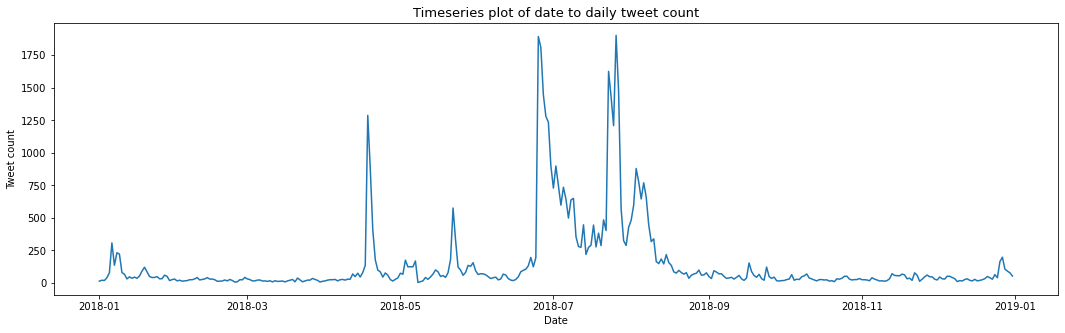

In [440]:
lists = sorted(tweetcount.items())                                  # Sorting and seperating the data
day, quant = zip(*lists)

plt.figure(figsize = [18,5])
plt.plot(day,quant)
plt.title('Timeseries plot of date to daily tweet count', size = 13)
plt.xlabel('Date')
plt.ylabel('Tweet count')
plt.show()

Similar shape but more defined. Around 10 times less tweet when noise is removed.

In [441]:
tweetcount = Counter()                                              # Initialise counter
with open('HeatFilter3CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = literal_eval(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

In [442]:
df = pd.DataFrame.from_dict(tweetcount, orient = 'index')
df.index.name = 'Date'
df['sent'] = 0

with open('HeatFilter3CSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = int(literal_eval(line[timestamp]))/1000                              # Convert timestamps to ms                     
        Date = (datetime.utcfromtimestamp(ts).date())                 # Turn ts into date
        df.loc[Date, 'sent'] = df.at[Date, 'sent'] + float(line[sentiment])
        
df['sent']=df['sent']/df[0]

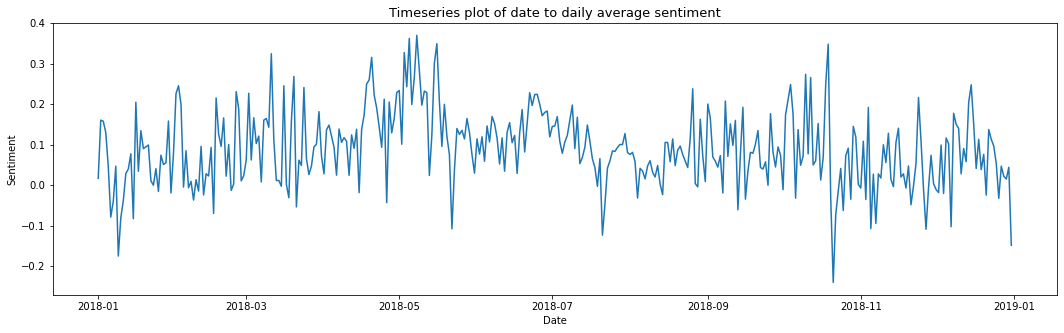

In [443]:
df = df.reset_index()
df = df.sort_values(by='Date')

plt.figure(figsize = [18,5])
plt.plot(df['Date'],df['sent'])
plt.title('Timeseries plot of date to daily average sentiment', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()